## Using Quanteda to analyze Scattertext's 2012 Conventions Corpus: Latent Sentiment Scaling

This is adapted from the Quanteda tutorial to use Latent Semantic Scaling (Wantanabe 2020) to induce a domain-specific sentiment lexicon and then plot it. We'll show how Scattertext can produce a interactive diagram comparable, and in many ways superior, to Quanteda's.  The package LSX (https://github.com/koheiw/LSX) (Wantanabe 2020)

This tutorial uses a corpus from 2012 US Political Convention speeches and the Python package Scattertext (Kessler 2017) accessed through Reticulate.

### References:

Kessler, Jason S. 2017. Scattertext: a Browser-Based Tool for Visualizing how Corpora Differ. ACL System Demonstrations. http://www.github.com/JasonKessler/scattertext 

Watanabe, Kohei. 2020. Latent Semantic Scaling: A Semisupervised Text Analysis Technique for New Domains and Languages. Communication Methods and Measures. https://github.com/koheiw/LSX

In [24]:
library(reticulate)
library(tidyverse)
require(quanteda)
require(quanteda.corpora)
require(LSX)

IRdisplay::display_html('<style>.container { width:100% !important; }</style>')

# Install Scattertext into a conda environment (in the notebook, the environment's name is py38).
# Ensure that you install Scattertext using pip (and not conda) after you've created your virtual environment

# For example, you may create a new virtual envirnoment and install Scattertext from the command line as follows:
# $ conda create -n py38 python=3.8
# $ source activatep py38
# (py38) $ pip install -U scattertext

use_condaenv("py38", required = TRUE)
st <- import("scattertext")
np <- import("numpy")
spacy <- import("spacy")

stopifnot(st['__version__'] >= '0.1.0.0')

source("scattertext.R")
st['__version__']

[1] "0.1.0.0"

Let's put the conventions corpus into a dataframe, and see the first two rows, indicating a textual dataset with each speaker's name, party and text listed.

In [25]:
convention_df <- st$SampleCorpora$ConventionData2012$get_data()  
tail(convention_df, 2)

,party,text,speaker
,<chr>,<chr>,<chr>
188,republican,"Absolutely. Thank you, Mr.Chairman. Welcome, everyone, to my home state of Florida, and we are so honored to host you. And I am honored to serve as your Republican National Committee co-chair. Every election, we heard that this is the most important election of our lifetime. This election is more than that. This election is the most important election in our nation's lifetime — — absolutely. In 1775 our Founding Fathers rose up to establish our liberty. Today we need to defeat a president whose actions threaten our liberty. In this way, we are in a similar position as our Founding Fathers. Just as they were called upon, we are being called upon. What they started, what they believed in, we must now defend. The danger for America is already here. It's in the form of the Democrat leaders in Washington. We have a Democrat Senate leader who refuses to meet his moral obligation to pass a budget for our government. We have a president that has bypassed the Senate confirmation process in order to appoint unaccountable czars to make and enforce policies on America's citizens, a president that by his executive action has changed immigration laws, imposed unconstitutional burdens on our states and issued overreaching regulations. We know the problem, America. Their names are Obama, Biden, Pelosi and Holder. What they have done and will continue to do should Obama be re-elected runs contrary to the values we believe in and the principles we stand for. It is our duty as citizen activists of this great Republican Party to fight to restore the values of our founding fathers. My fellow members, this fight is not just about an election, and it's not about our party. Our fight is about our country, and we cannot lose this battle. Our founding fathers made huge personal sacrifices for what they believed in. The time is now for us to do the same. I am a proud grass-roots activist, one of many in my state and countless others from across this great country. Today, we need as many grass-roots activists from all walks of life and throughout this great nation to stand with us. The sacrifices we meet and the sacrifices we will make are nothing compared to the sacrifices our children and our grandchildren will face if we don't take back this country on November 6th by electing Mitt Romney and Paul Ryan. We must take this election house by house, precinct by precinct, city by city and state by state to bring our proud conservative message of Mitt Romney and Paul Ryan to every voter in America. Thank you. God bless each of you. God bless our proud military and their families. And may God continue to bless the United States of America. Godspeed.",SHARON DAY
189,republican,"I am thrilled to add Utah's voice in support for Mitt Romney. Let me tell you about the America I know. My parents immigrated to this country with $10 in their pockets and a hope that the America they heard about really did exist. When tough times came, they didn't look to Washington; they looked within. So the America I grew up knowing was centered in self-reliance and filled with the possibilities of living the American Dream. The America I know is grounded in the determination found in patriots and pioneers, in small businesses with big ideas. It's found in the farmers who work in the beauty of our landscape and our heroic military. It's found in the Olympic athletes and every child who looks at the seemingly impossible and says, I can do that. That's the America I know. President Obama's version of America is a divided one, often pitting us against each other based on income level, gender and social status. His policies have failed us. We're not better off than we were four years ago, and no rhetoric, bumper sticker or Hollywood campaign ad can change that. Mr. President, I'm here to tell you the American people are awake, and we're not buying what you're selling in 2012. The American dream isn't just my story. It isn't just yo

Since we will perform a sentiment lexicon adaptation, let's build a Quanteda sentence-level corpus, and tokenize it removing items which don't appear to be words. We'll also remove terms which appear less than twice.

In [15]:
conv_corp_sent <- corpus(convention_df$text, 
                         docvars = convention_df[,c('party', 'speaker')]) %>%
    corpus_reshape(to = "sentences")

conv_toks_sent <- conv_corp_sent %>% 
    tokens(remove_punct = TRUE, remove_symbols = TRUE, 
           remove_numbers = TRUE, remove_url = TRUE) %>% 
    tokens_remove(stopwords("en", source = "marimo")) %>%
    tokens_remove(c("*-time", "*-timeUpdated", "GMT", "BST", "*.com"))  

# create a document feature matrix from the tokens object
conv_dfmat_sent <- conv_toks_sent %>% 
    dfm(remove = "") %>% 
    dfm_trim(min_termfreq = 4)

Next, we'll use Latent Semantic Scaling to predict 300 sentiment-laden terms. Following the tutorial https://tutorials.quanteda.io/machine-learning/lss/, we use a small, general-purpose sentiment word list to induce our domain-specific term-list.

In [16]:
seed <- as.seedwords(data_dictionary_sentiment)
print(seed)

conv_tmod_lss <- textmodel_lss(conv_dfmat_sent,
                               seeds = seed,
                               k = 300, 
                               cache = TRUE)

       good        nice   excellent    positive   fortunate     correct 
          1           1           1           1           1           1 
   superior         bad       nasty        poor    negative unfortunate 
          1          -1          -1          -1          -1          -1 
      wrong    inferior 
         -1          -1 


Reading cache file: lss_cache/svds_3835d0fa311a57e7.RDS



Using LSX's `textplot_terms` ggplot2-based function, we can a text-based scatterplot of words by frequency and induced sentiment scale.T he `geom_text_repel` function is used to prevent in-focus label overlaps.

Negative terms in the LSD 2015 sentiment lexicon are highlighted, while remaing sentiment-loaded terms are in light grey. The aggressive repositioning of terms makes this chart very difficult to read.  It is more readable if fewer termsa re included, but that diminishes the utility of the plot. Scattertext's point labeling strategy which hides labels it can't position close to their points provides a more elegant solution, and its interactivity ensures one can see what unlabled points correspond to.



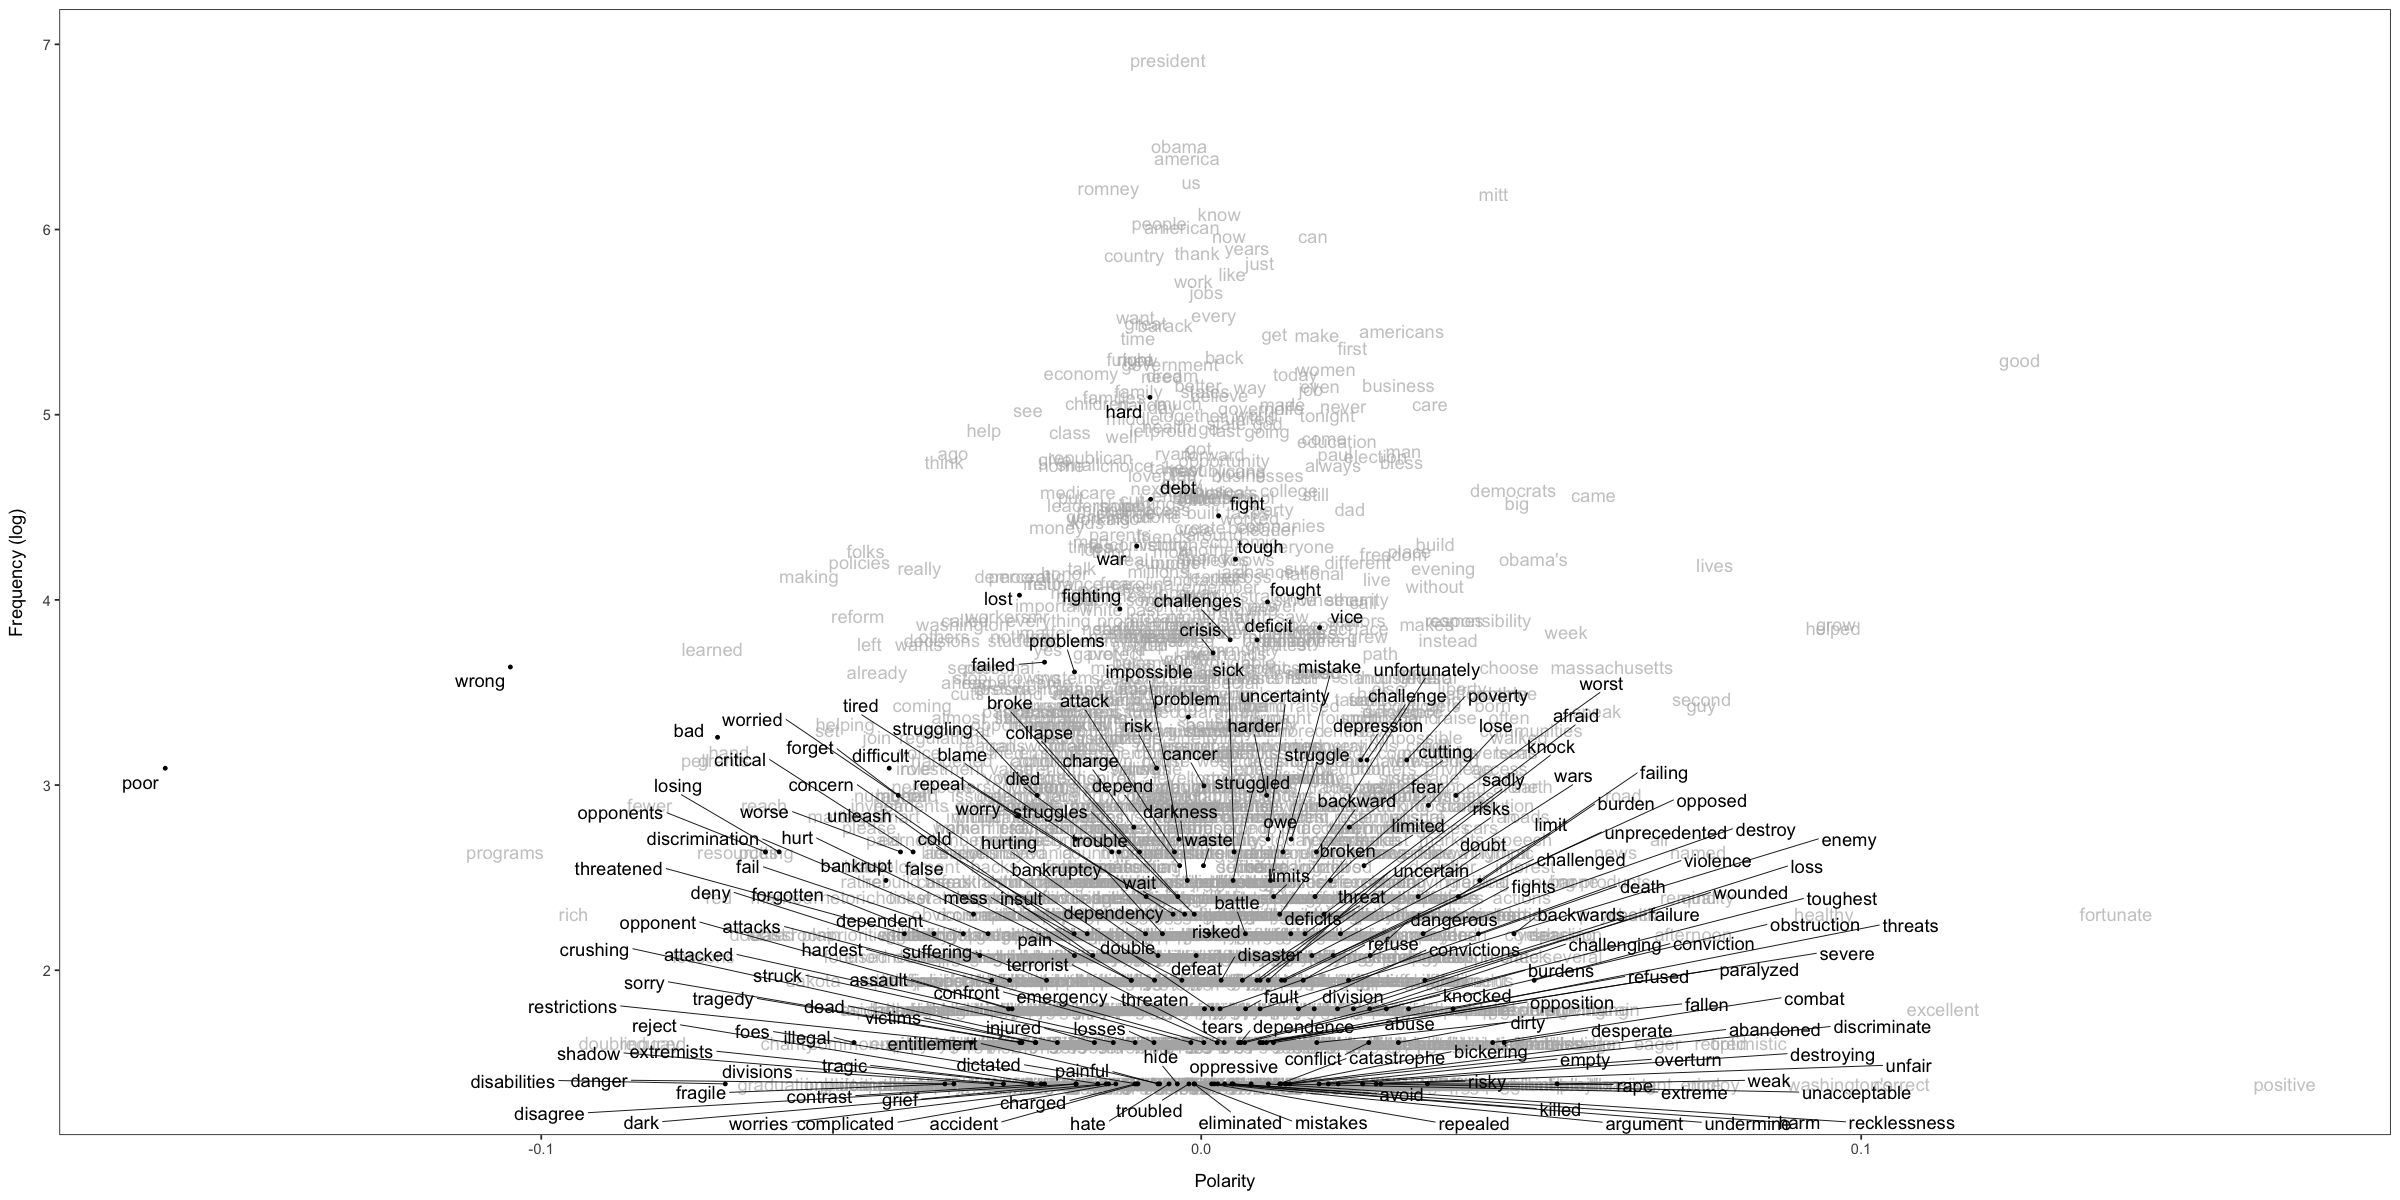

In [17]:
options(repr.plot.width=20, repr.plot.height=10)
textplot_terms(conv_tmod_lss, data_dictionary_LSD2015["negative"])

Next, we'll filter the sentence-level DFM for words which appear in the induced word list, filter the corpus to sentences which contain sentiment seed words.

Finally, we'll use the `st.corpus.from.quanteda` function (See "scattertext.R" in this package) to combine the Quanteda DFM and Corpus objects into a Scattertext Corpus object.

We'll include "party" as the as the category for the plot. Below, we'll show how to use leave out the concept of document categories.

In [18]:
conv_sentiment_dfm_sent <- dfm_keep(conv_dfmat_sent, pattern=names(conv_tmod_lss$beta)) %>% 
    dfm_subset(ntoken(.) >= 1)

conv_sentiment_corp_sent <- conv_corp_sent[rownames(conv_sentiment_dfm_sent)]

conv_corpus <- st.corpus.from.quanteda(
    conv_sentiment_dfm_sent, 
    conv_sentiment_corp_sent, 
    category=as.character(conv_sentiment_dfm_sent$party)
)

Next, let's make a Dataframe Scattertext can use for plotting. We'll include term positions and sentiment membership.

The table includes the Beta and Frequency columns we'll scale to form the X and Y plotting positions. These are in the `X` and `Y` columns in plot_df.

Next, we project them onto the chart in the `Xpos` and `Ypos` columns. These are values $\in [0, 1]$. The $\log_2$ of term frequencies are taken, and then these are scaled to the $[0,1]$ inteval using the `st$Scalers$scale` function from Scattertext. Next Beta values are projected, where the valuein the middle of the chart is 0, using `st$Scalers$scale_center_zero_abs(.)`.

In [19]:
plot_df <- tibble(
    Beta=conv_tmod_lss$beta, 
    Frequency=conv_tmod_lss$freq, 
    Word=names(conv_tmod_lss$beta)
) %>%
  slice(match(conv_corpus$get_terms(), Word)) %>%
  column_to_rownames('Word') %>%
  add_column(
      X = .$Beta,
      Y = .$Frequency,
      Xpos = .$Beta %>% 
        np$array(.) %>% 
        st$Scalers$scale_center_zero_abs(.),
      Ypos = .$Frequency %>% 
        log(., 2) %>%
        np$array(.) %>% 
        st$Scalers$scale(.),
      lsd2015.pos = rownames(.) %in% pattern2fixed(
          data_dictionary_LSD2015$positive,
          types = rownames(.),
          valuetype = 'glob',
          case_insensitive = TRUE
      ) %>% unlist,
      lsd2015.neg = rownames(.) %in% pattern2fixed(
          data_dictionary_LSD2015$negative,
          types = rownames(.),
          valuetype = 'glob',
          case_insensitive = TRUE
      ) %>% unlist,
      
  )


Next, we'll specificy the label and point colors for each point ploted. We'll color terms/points appearing in the negative sentiment term set red, and the others grey. These will be placed in the `Color` column.

We'll prioritze labeling the points in the negative lexicon over others using the `LabelPriority` column.  Finally, we'll let labels overlap non-negative points usings the `CensorPoint` column.

In [37]:
neg_plot_df <- left_join(
    plot_df %>% rownames_to_column('Word'), 
    tibble(Color=c("#d35c37", "#d6c6b9"), 
           lsd2015.neg=c(TRUE, FALSE))
) %>% 
  column_to_rownames('Word') %>% 
  add_column(
      LabelPriority = (!.$lsd2015.neg) %>% as.integer
  )

Joining, by = "lsd2015.neg"



In [51]:
html = st$dataframe_scattertext(
    conv_corpus,
    plot_df=neg_plot_df,
    metadata=paste(conv_sentiment_corp_sent$speaker, ";", conv_sentiment_corp_sent$party),
    y_label='Log Frequency',
    x_label='Beta (Sentiment)',
    x_axis_labels=c('Negative', 'Neutral', 'Positive'),
    tooltip_columns=c('Beta', 'Frequency'),
    header_names=py_dict(list('upper', 'lower'),list('Most Positive', 'Most Negative')),
    term_description_columns=c('Frequency', 'Beta', 'lsd2015.pos', 'lsd2015.neg'),
    left_list_column='Beta',
    color_column='Color',
    text_color_column='Color',
    label_priority_column='LabelPriority'
)

paste('<h2 align=center>Sentiment Scaling; red indicate membership in the negative in the LSD 2015 sentiment lexicon</h2>', 
      html,  sep=' ') %>% cat(file="sentiment_scaling_conventions_negative.html")

In [52]:


IRdisplay::display_html('<iframe src="sentiment_scaling_conventions_negative.html" width=1500, height=700></iframe>')

In [38]:
pos_plot_df <- left_join(
    plot_df %>% rownames_to_column('Word'), 
    tibble(Color=c("#1b4b5a", "#d6c6b9"), 
           lsd2015.pos=c(TRUE, FALSE))
) %>% 
  column_to_rownames('Word') %>% 
  add_column(
      LabelPriority = (!.$lsd2015.pos) %>% as.integer
  )

Joining, by = "lsd2015.pos"



In [49]:
html = st$dataframe_scattertext(
    conv_corpus,
    plot_df=pos_plot_df,
    metadata=paste(conv_sentiment_corp_sent$speaker, ";", conv_sentiment_corp_sent$party), 
    y_label='Log Frequency',
    x_label='Beta (Sentiment)',
    x_axis_labels=c('Negative', 'Neutral', 'Positive'),
    tooltip_columns=c('Beta', 'Frequency'),
    header_names=py_dict(list('upper', 'lower'),list('Most Positive', 'Most Negative')),
    term_description_columns=c('Frequency', 'Beta', 'lsd2015.pos', 'lsd2015.neg'),
    left_list_column='Beta',
    color_column='Color',
    text_color_column='Color',
    label_priority_column='LabelPriority'
)

paste('<h2 align=center>Sentiment Scaling; blue indicate membership in the postivie in the LSD 2015 sentiment lexicon</h2>', 
      html,  sep=' ') %>% cat(file="sentiment_scaling_conventions_positive.html")

In [50]:


IRdisplay::display_html('<iframe src="sentiment_scaling_conventions_positive.html" width=1500, height=700></iframe>')